Connect to python API

In [27]:
%matplotlib inline

In [28]:
import json
config = {}
with open('config.json') as data_file:    
    config = json.load(data_file)


In [29]:
import twitter

# XXX: Go to http://dev.twitter.com/apps/new to create an app and get values
# for these credentials, which you'll need to provide in place of these
# empty string values that are defined as placeholders.
# See https://dev.twitter.com/docs/auth/oauth for more information 
# on Twitter's OAuth implementation.

CONSUMER_KEY = config['twitter']['CONSUMER_KEY']
CONSUMER_SECRET = config['twitter']['CONSUMER_SECRET']
OAUTH_TOKEN = config['twitter']['OAUTH_TOKEN']
OAUTH_TOKEN_SECRET = config['twitter']['OAUTH_TOKEN_SECRET']


auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                           CONSUMER_KEY, CONSUMER_SECRET)

twitter_api = twitter.Twitter(auth=auth)

# Nothing to see by displaying twitter_api except that it's now a
# defined variable

Get US and World Trends

In [30]:
# The Yahoo! Where On Earth ID for the entire world is 1.
# See https://dev.twitter.com/docs/api/1.1/get/trends/place and
# http://developer.yahoo.com/geo/geoplanet/

WORLD_WOE_ID = 1
US_WOE_ID = 23424977
NYS_WOE_ID = 2459115
TX_WOE_ID = 2347602
UK_WOE_ID = 23424975


# Prefix ID with the underscore for query string parameterization.
# Without the underscore, the twitter package appends the ID value
# to the URL itself as a special case keyword argument.
trends = []

trends.append(twitter_api.trends.place(_id=US_WOE_ID)) #twitter_api.trends.place(_id=WORLD_WOE_ID)
trends.append(twitter_api.trends.place(_id=UK_WOE_ID)) #twitter_api.trends.place(_id=US_WOE_ID)

In [31]:
import json

#print json.dumps(trends[0], indent=1)
#print
#print json.dumps(trends[1], indent=1)

In [32]:
trend_set = []

trend_set.append(set([trend['name'] 
                        for trend in trends[0][0]['trends']]))

trend_set.append(set([trend['name'] 
                     for trend in trends[1][0]['trends']]))

common_trends = trend_set[0].intersection(trend_set[1])

trends_subtract = trend_set[1] - trend_set[0]

print ("Trend 1: \n" , trend_set[0])
print ("Trend 2: \n" , trend_set[1])

print ("\n{} common trends: \n".format(len(common_trends)), common_trends)

Trend 1: 
 {'Cash Machine', 'Napalm Girl', 'Ed Davis', '#BuenViernes', '#MoneyIsntImportantBut', '#HITsm', '#NeverForget', '#FlashbackFriday', 'Bill Nojay', '#CampCamp', 'Charleston Southern', '#boycottNFL', 'Pep Hamilton', 'Alberto Del Rio', '#NationalTeddyBearDay', 'General Motors', '#EnigmaLoungeTonight', '#VVS16', '#FitnessFriday', 'Wickenburg', '#TravelSkills', '#September11', 'Russian TV', '#NewMusicFriday', '#NorthKorea', '#PrisonStrike', '#KershawDay', '#FreeDesiigner', '#MansionElanTONIGHT', 'The Hillary Clinton', 'Free Fire', 'Wiz and Amber', 'Iman Shumpert', '#WINGS5', '#SmartPhoneOfMyDreams', '#MakeAMovieMoreCanadian', 'Alien Nation', '#FridayFeeling', 'Nocturnal Animals', 'Dreamcast', 'Nas Album Done', '#911Day', '#WeLoveYouLauren', '#opioidhack', 'Louie Gohmert', '#NCTStanSelcaDay', 'Big Liar', '#BlueFriday', '#SNLaSong', '#Top5ZeldaGames'}
Trend 2: 
 {'Wall Of Fire', 'David Moyes', 'Goal of the Month', 'Scotland Yard', 'Super Hans', 'Nic Cruwys', '#MoneyIsntImportantBut'

In [33]:
queries = list(trend_set[0]) + list(trend_set[1])
print (len(queries))

100


In [45]:
# Import unquote to prevent url encoding errors in next_results
#from urllib import unquote
from urllib.parse import unquote

# XXX: Set this variable to a trending topic, 
# or anything else for that matter. The example query below
# was a trending topic when this content was being developed
# and is used throughout the remainder of this chapter.

#queries = list(common_trends)



count = 500

trend_tweets = {}

# See https://dev.twitter.com/docs/api/1.1/get/search/tweets

for q in queries:
    print ("fetching {}".format(q))
    
    search_results = twitter_api.search.tweets(q=q, count=count)

    statuses = search_results['statuses']


    numberOfTweets = 100
    fetchIterations = int(numberOfTweets/count)

    for _ in range(fetchIterations):
        print ("Length of statuses {} for {}".format(len(statuses), q))
        try:
            next_results = search_results['search_metadata']['next_results']
        except e: # No more results when next_results doesn't exist
            break

        # Create a dictionary from next_results, which has the following form:
        # ?max_id=313519052523986943&q=NCAA&include_entities=1
        kwargs = dict([kv.split('=') for kv in unquote(next_results[1:]).split("&") ])    


        search_results = twitter_api.search.tweets(**kwargs)
        statuses += search_results['statuses']

    trend_tweets[q] = statuses


fetching Cash Machine
fetching Napalm Girl
fetching Ed Davis
fetching #BuenViernes
fetching #MoneyIsntImportantBut
fetching #HITsm
fetching #NeverForget
fetching #FlashbackFriday
fetching Bill Nojay
fetching #CampCamp
fetching Charleston Southern
fetching #boycottNFL
fetching Pep Hamilton
fetching Alberto Del Rio
fetching #NationalTeddyBearDay
fetching General Motors
fetching #EnigmaLoungeTonight
fetching #VVS16
fetching #FitnessFriday
fetching Wickenburg
fetching #TravelSkills
fetching #September11
fetching Russian TV
fetching #NewMusicFriday
fetching #NorthKorea
fetching #PrisonStrike
fetching #KershawDay
fetching #FreeDesiigner
fetching #MansionElanTONIGHT
fetching The Hillary Clinton
fetching Free Fire
fetching Wiz and Amber
fetching Iman Shumpert
fetching #WINGS5
fetching #SmartPhoneOfMyDreams
fetching #MakeAMovieMoreCanadian
fetching Alien Nation
fetching #FridayFeeling
fetching Nocturnal Animals
fetching Dreamcast
fetching Nas Album Done
fetching #911Day
fetching #WeLoveYouLaure

In [46]:
import re
tweetText = trend_tweets[queries[0]][0]['text']
print (tweetText)
urlRegEx = "http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
noUrl = re.sub(urlRegEx, '', tweetText)
print ('nourl', noUrl)

print (len(queries), len(trend_tweets.keys()))
print (trend_tweets[queries[0]][0]['lang'])
print (json.dumps(trend_tweets[queries[0]][0], indent=1))



RT @BIGBABYDRAM: #CashMachine 💸
Spotify: https://t.co/0QQF4owwrG 
iTunes: https://t.co/zESBnGE3NR
SoundCloud: https://t.co/PZGKDqYOEP https…
nourl RT @BIGBABYDRAM: #CashMachine 💸
Spotify:  
iTunes: 
SoundCloud:  https…
100 91
en
{
 "retweeted": false,
 "in_reply_to_screen_name": null,
 "in_reply_to_status_id": null,
 "text": "RT @BIGBABYDRAM: #CashMachine \ud83d\udcb8\nSpotify: https://t.co/0QQF4owwrG \niTunes: https://t.co/zESBnGE3NR\nSoundCloud: https://t.co/PZGKDqYOEP https\u2026",
 "in_reply_to_status_id_str": null,
 "id": 774292969163591680,
 "entities": {
  "urls": [
   {
    "url": "https://t.co/0QQF4owwrG",
    "indices": [
     41,
     64
    ],
    "expanded_url": "http://spoti.fi/2cenbBc",
    "display_url": "spoti.fi/2cenbBc"
   },
   {
    "url": "https://t.co/zESBnGE3NR",
    "indices": [
     74,
     97
    ],
    "expanded_url": "https://itun.es/us/VfmMeb",
    "display_url": "itun.es/us/VfmMeb"
   },
   {
    "url": "https://t.co/PZGKDqYOEP",
    "indices": [
     11

In [47]:
#print trend_tweets.keys()
import itertools

concatinatedText = {}
noUrlText = {}

urlRegEx = "http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
noUrl = re.sub(urlRegEx, '', tweetText)


for trend in trend_tweets.keys():
    tweet_list = trend_tweets[trend]
    #print tweet_list[0]
    #only english tweets
    concatinatedText[trend] = ''.join([ status['text'] if status['lang']=='en' else ''
                                for status in tweet_list])
    
    noUrlText[trend] = ''.join([ re.sub(urlRegEx, '', status['text']) if status['lang']=='en' else ''
                                for status in tweet_list])
    

print (len(trend_tweets.keys()))
#print concatinatedText['#SocialismChecklist']

91


In [48]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=2, stop_words = 'english',\
strip_accents = 'unicode', lowercase=True, ngram_range=(1,2),\
norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)
# X is a sparce martrix. each row containes the tfidfs for a trend.
X = vectorizer.fit_transform(noUrlText.values())
D = -(X * X.T).todense() # dot products
XX = X.todense()
#print D
print (XX) # dense matrix

countVectorizer = CountVectorizer(stop_words = 'english',\
strip_accents = 'unicode', lowercase=True)
CX = countVectorizer.fit_transform(noUrlText.values())




[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.08601808  0.          0.1338059  ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.03343791  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]


In [49]:
import numpy as np

indices = np.argsort(vectorizer.idf_)[::-1]
features = vectorizer.get_feature_names()
top_n = 100
top_features = [features[i] for i in indices[:top_n]]
#print '\n Top {} words normalized by document frequency'.format(top_n)
#print top_features
#freqs = [(word, X.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]
#sort from largest to smallest
#print sorted (freqs, key = lambda x: -x[1])

features = countVectorizer.get_feature_names()
top_n = 100
top_features = [features[i] for i in indices[:top_n]]
#print '\n Top {} words'.format(top_n)
#print top_features

freqs = [(word, CX.getcol(idx).sum()) for word, idx in countVectorizer.vocabulary_.items()]
#sort from largest to smallest
print ('\n Top words by count')
top_words = sorted (freqs, key = lambda x: -x[1])
print (top_words[0:100])


 Top words by count
[('rt', 3989), ('amp', 547), ('https', 430), ('just', 284), ('new', 268), ('time', 263), ('free', 226), ('like', 213), ('today', 206), ('hillary', 200), ('news', 181), ('gold', 180), ('big', 179), ('day', 171), ('man', 170), ('got', 168), ('years', 164), ('clinton', 157), ('nas', 157), ('august', 157), ('great', 148), ('win', 141), ('says', 139), ('month', 135), ('people', 134), ('trump', 131), ('love', 128), ('year', 127), ('don', 125), ('paralympics', 124), ('super', 123), ('wins', 122), ('happy', 120), ('fridayfeeling', 120), ('trailer', 119), ('tv', 118), ('good', 118), ('september11', 117), ('russian', 117), ('11', 117), ('liar', 115), ('week', 115), ('really', 113), ('thornhill', 113), ('neverforget', 113), ('breaking', 112), ('album', 110), ('goal', 110), ('tomorrow', 110), ('http', 109), ('bronze', 108), ('club', 108), ('quest', 108), ('ed', 107), ('night', 106), ('fans', 106), ('premierleague', 106), ('sound', 105), ('nation', 105), ('flashbackfriday', 105

In [50]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
coords = model.fit_transform(XX) 
print (coords)


[[  58.19836522   39.65909314]
 [   2.54037094   56.8485297 ]
 [  12.9651443   -86.84758453]
 [ -79.41041407  -55.44075979]
 [ -27.08080532 -105.5638549 ]
 [  -8.92817124   -4.08985479]
 [   6.09534464  -52.53364604]
 [ -22.38567038    4.37432145]
 [  93.15500527    8.32560625]
 [ -25.94419766  -28.804573  ]
 [  32.34404706  -52.72662736]
 [  53.97088691  -21.24442697]
 [ -29.97693755   41.37633089]
 [   3.64637845  -75.46126284]
 [   4.69939237   -1.05255904]
 [  29.31745277   50.56754889]
 [ -69.55378922   57.60991071]
 [   0.56229772  103.8141561 ]
 [  78.82277462  -57.67439068]
 [ -18.74410444   60.11976906]
 [   3.26951864  -43.82887402]
 [ -72.88463409   -3.31411097]
 [  54.13542403   57.22388923]
 [ -55.45624408  -54.62934719]
 [ -26.23467681   18.38191213]
 [ -41.76875498   24.77317433]
 [ -96.87060108  -28.1628471 ]
 [  84.70174077  -93.63659316]
 [ 249.4337017   172.7389932 ]
 [ -42.61168849    9.27265557]
 [  69.9029898   -33.8235682 ]
 [  -0.64162038   29.45966532]
 [  35.0

In [51]:
#import matplotlib.pyplot as plt

vis_x = coords[:, 0]
vis_y = coords[:, 1]


91 91


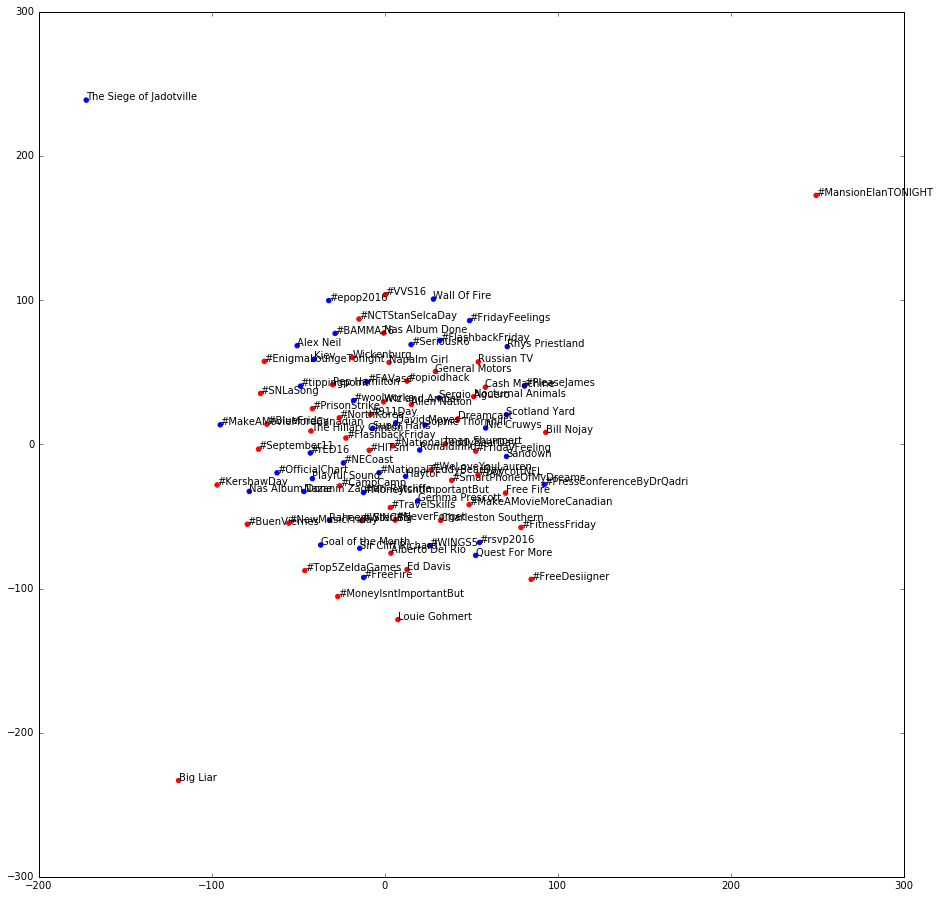

In [52]:
import matplotlib.pyplot as plt

color = ['#FF0000'] * 50 + ['#0000FF'] * len(list(trends_subtract))


print (len(vis_x), len(color))

plt.scatter(vis_x, vis_y, color=color)

for i, txt in enumerate(queries):
    if i<len(vis_x): plt.annotate(txt, (vis_x[i],vis_y[i]))

fig = plt.gcf()
fig.set_size_inches(15.5, 15.5)

plt.show()

